<h1> Optimisation du modèle pour l'embedding USE et GLOVE</H1>

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import time
import myfunctions as myf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

import os
from IPython.display import clear_output

# Afficher toutes les colonnes du dataframe
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_columns', 20)

In [2]:
from gensim.models import Word2Vec, FastText, KeyedVectors
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, BatchNormalization, LSTM, Layer, GRU, Bidirectional, TextVectorization, Input, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.python.framework import tensor_spec

2024-05-13 10:21:10.662143: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 10:21:10.693281: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 10:21:11.211156: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [18]:
# Lancement de Mlflow
# Lancement de Mlflow
import mlflow
from mlflow.models import infer_signature
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, TensorSpec, ColSpec
# Démarrer le serveur MLflow
mlflow_process = myf.start_mlflow_server()

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("projet_7_final_models")

2024/05/13 11:51:05 INFO mlflow.tracking.fluent: Experiment with name 'projet_7_final_models' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/jul/OpenClassroom/mlflow/583370408327980186', creation_time=1715593865807, experiment_id='583370408327980186', last_update_time=1715593865807, lifecycle_stage='active', name='projet_7_final_models', tags={}>

# Preparation des données et fonctions

#### Data prep

In [11]:
df = pd.read_csv('data/tweets_tokenized_test_1.csv')

X_full = df['dl']
y_full = df['label']
_, X, _, y = train_test_split(X_full, y_full, test_size=0.3, stratify=y_full, random_state=42)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [12]:
embedding_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

def embed_use_batches_fct(data, batch_size):
    embeddings = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        batch_embeddings = embedding_model(batch)
        embeddings.append(batch_embeddings)
    return np.concatenate(embeddings)

X_train_use = embed_use_batches_fct(X_train, 64)
X_val_use = embed_use_batches_fct(X_val, 64)
X_test_use = embed_use_batches_fct(X_test, 64)

2024-05-05 16:51:06.920927: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-05 16:51:06.976750: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-05 16:51:06.976814: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-05 16:51:06.979306: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-05 16:51:06.979339: I external/local_xla/xla/stream_executor

In [41]:
model_glove = mlflow.tensorflow.load_model("runs:/ed819e191be24adda238c88da7d1f90f/model_glove_optimized")
model_use = mlflow.tensorflow.load_model("runs:/a19e31ed2aa14d5d839fa23e9b00ba6f/model_use_optimized")
model_glove.trainable = False
model_use.trainable = False
glove_weights = model_glove.get_weights()
use_weights = model_use.get_weights()

2024/05/05 18:10:10 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


2024/05/05 18:10:37 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


#### Optuna

In [49]:
def objective_ensemble(trial):

    batch_size = 32
    num_epochs = 50
    patience = 5

    # Créer les listes de résultats
    val_list=[]
    test_list=[]

    # Suggérer les paramètres

    dense_units_1 = trial.suggest_categorical('A_dense_units', [2, 4, 16, 64])
    dense_1_l1_rate = trial.suggest_categorical('B_dense_1_l1_rate', [0, 0.001])
    dense_1_l2_rate = trial.suggest_categorical('C_dense_1_l2_rate', [0, 0.001])
    dense_1_dropout = trial.suggest_categorical('D_dense_1_dropout', [0, 0.25])


    
    for i in range(2):

        # Créer le modèle
        # -------------------------------------------------------------------------------

        # Créer les Inputs à à la forme correcte
        input_glove = Input(shape=model_glove.input_shape[1:])
        input_use = Input(shape=model_use.input_shape[1:])

        model_glove_output = model_glove(input_glove)
        model_use_output = model_use(input_use)

        # Créer un nouveau modèle en utilisant les sorties des modèles existants comme entrées
        combined_output = concatenate([model_glove_output, model_use_output])

        # Ajouter des couches supplémentaires au besoin
        intermediate_layer = Dense(dense_units_1, activation='relu', kernel_regularizer=l1_l2(l1=dense_1_l1_rate, l2=dense_1_l2_rate))(combined_output)
        intermediate_layer = Dropout(dense_1_dropout)(intermediate_layer)

        # Ajouter la couche de sortie
        output = Dense(1, activation='sigmoid')(intermediate_layer)

        # Créer le modèle final
        ensemble_model = Model(inputs=[input_glove, input_use], outputs=output)
        
        # Compiler le modèle
        ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


        # Tester le modèle
        # -------------------------------------------------------------------------------
                
        val_acc_max, test_acc= optuna_test_callbacks(ensemble_model, [X_train, X_train_use], [X_val, X_val_use], [X_test, X_test_use], num_epochs, patience, batch_size)

        # Rajouter les accuracies à la liste
        val_list.append(val_acc_max)
        test_list.append(test_acc)

    val_test_mean, test_best, test_mean, val_best, val_mean  = optuna_calculate_results_fct(trial, val_list, test_list)

    # Retourner la métrique de performance à optimiser
    return test_mean

In [50]:
name_study = "ensemble_optimization_2"

# Effacer l'étude si besoin
optuna_del_study_fct(name_study)

# Exécution de l'optimisation avec Optuna
trials_number  = 25

study = optuna.create_study(
    direction='maximize', 
    storage='sqlite:///study.db', 
    study_name= name_study
)

study.optimize(objective_ensemble, n_trials=trials_number)

[I 2024-05-05 18:26:24,360] A new study created in RDB with name: ensemble_optimization_2
[I 2024-05-05 18:27:40,435] Trial 0 finished with value: 0.7934 and parameters: {'A_dense_units': 16, 'B_dense_1_l1_rate': 0, 'C_dense_1_l2_rate': 0.001, 'D_dense_1_dropout': 0}. Best is trial 0 with value: 0.7934.
[I 2024-05-05 18:28:26,146] Trial 1 finished with value: 0.8101 and parameters: {'A_dense_units': 64, 'B_dense_1_l1_rate': 0.001, 'C_dense_1_l2_rate': 0, 'D_dense_1_dropout': 0}. Best is trial 1 with value: 0.8101.
2024-05-05 18:28:37.886608: W external/local_tsl/tsl/framework/bfc_allocator.cc:487] Allocator (GPU_0_bfc) ran out of memory trying to allocate 169.54MiB (rounded to 177780992)requested by op StatefulPartitionedCall/adam/UnsortedSegmentSum_1
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-05-05 18:28:37.886696: I ex

ResourceExhaustedError: Graph execution error:

Detected at node adam/UnsortedSegmentSum_1 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 604, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_1114/2988458524.py", line 15, in <module>

  File "/usr/local/lib/python3.11/dist-packages/optuna/study/study.py", line 451, in optimize

  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 62, in _optimize

  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 159, in _optimize_sequential

  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial

  File "/tmp/ipykernel_1114/1068245580.py", line 52, in objective_ensemble

  File "/tmp/ipykernel_1114/2342017766.py", line 15, in optuna_test_callbacks

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 323, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 105, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 72, in train_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py", line 269, in apply_gradients

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py", line 330, in apply

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py", line 380, in _backend_apply_gradients

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/optimizer.py", line 107, in _backend_update_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/optimizer.py", line 121, in _distributed_tf_update_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/optimizer.py", line 118, in apply_grad_to_update_var

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/adam.py", line 134, in update_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/numpy.py", line 5467, in subtract

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/sparse.py", line 487, in sparse_wrapper

OOM when allocating tensor with shape[222226,200] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node adam/UnsortedSegmentSum_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_1013633]

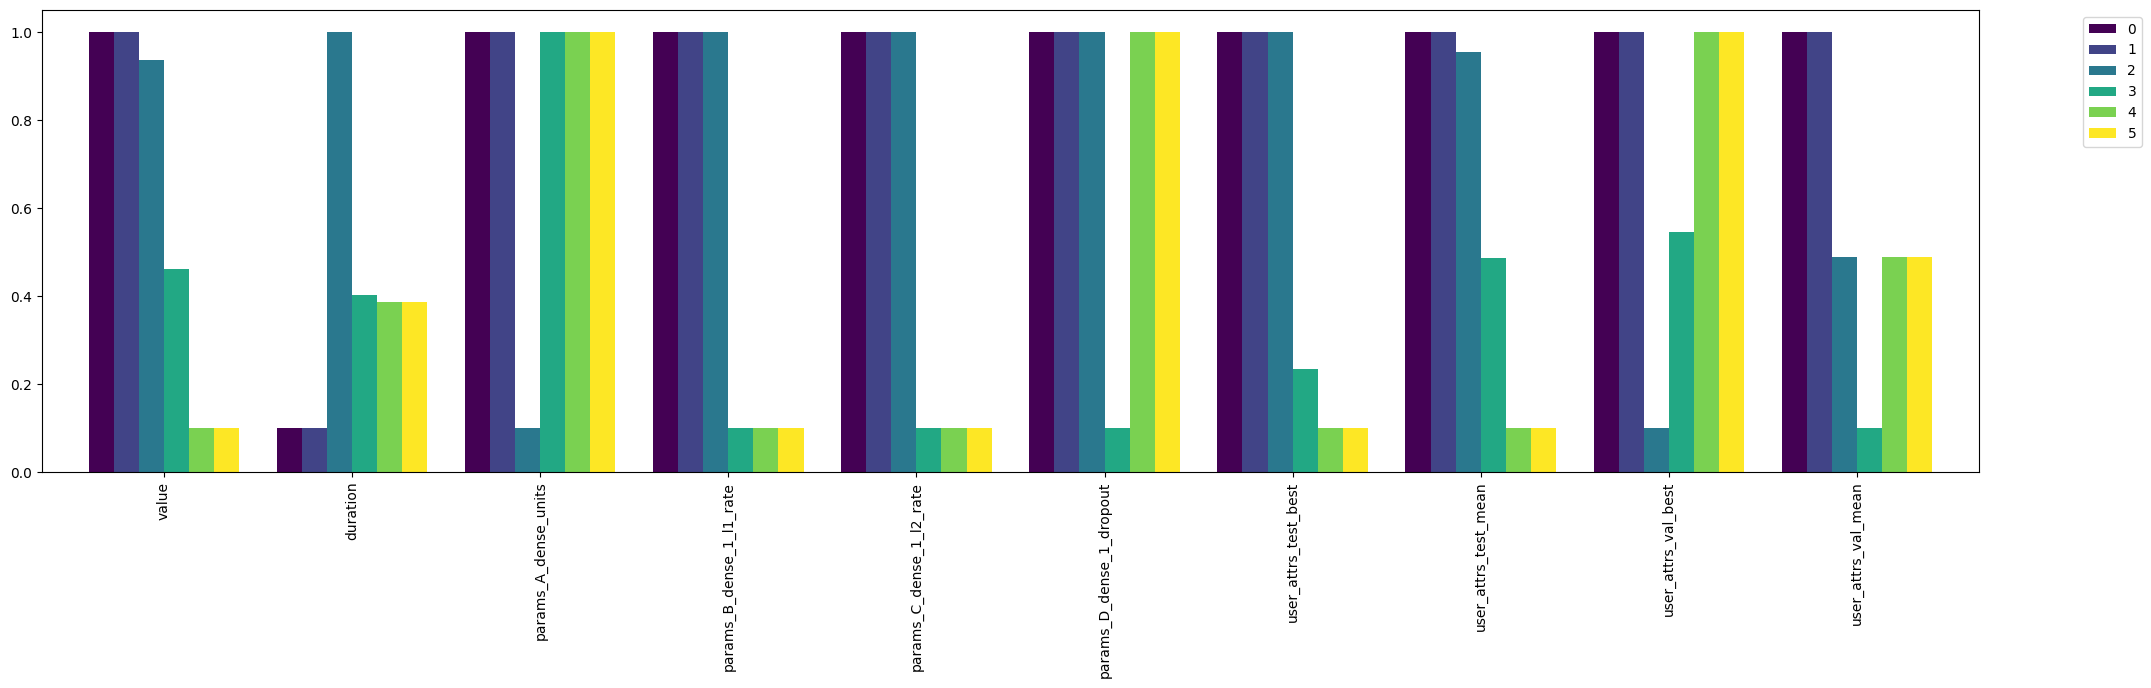

,value,duration,params_A_dense_units,params_B_dense_1_l1_rate,params_C_dense_1_l2_rate,params_D_dense_1_dropout,user_attrs_test_best,user_attrs_test_mean,user_attrs_val_best,user_attrs_val_mean
first,0.810700,0.931100,16.0,0.001,0.001,0.250,0.80540,0.80390,0.82430,0.8175
first_quarter,0.810700,0.931100,16.0,0.001,0.001,0.250,0.80540,0.80390,0.82430,0.8175
first_half,0.807300,2.440505,9.0,0.001,0.001,0.250,0.80540,0.79920,0.81905,0.8154
last_half,0.781775,1.439079,16.0,0.000,0.000,0.125,0.79655,0.74975,0.82165,0.8138
last_quarter,0.762300,1.409710,16.0,0.000,0.000,0.250,0.79500,0.70920,0.82430,0.8154
last,0.762300,1.409710,16.0,0.000,0.000,0.250,0.79500,0.70920,0.82430,0.8154


In [ ]:
name_study = "ensemble_optimization_2"
optuna_graph_results_fct(study_name=name_study)

#### Moyenne des prédictions

In [47]:
pred_glove_r = model_glove.predict(X_test)
pred_use_r = model_use.predict(X_test_use)
pred_glove = pred_glove_r.flatten()
pred_use = pred_use_r.flatten()
pred = (pred_glove + pred_use) / 2
y_pred = np.round(pred)

print('accuracy mean  :', accuracy_score(y_test, y_pred))
print('accuracy glove :', accuracy_score(y_test, np.round(pred_glove)))
print('accuracy use   :', accuracy_score(y_test, np.round(pred_use)))

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
accuracy mean  : 0.8294979079497908
accuracy glove : 0.799163179916318
accuracy use   : 0.8085774058577406
